# Wafer Defect Detection

This notebook walks through the process of building and training a model to detect defects on semiconductor wafers.

## 1. Imports

Import all the necessary libraries.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from scipy import interpolate

## 2. Model Definition

Here we define the Convolutional Neural Network (CNN) architecture.

In [89]:
def build_model(input_shape, num_classes):
    """
    Builds a convolutional neural network (CNN) for image classification.

    Args:
        input_shape (tuple): The shape of the input images (height, width, channels).
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled CNN model.
    """
    model = keras.Sequential([
        # Conv layer 1
        keras.layers.Conv2D(16, (3, 3), padding="same", activation="relu", input_shape=input_shape),
        keras.layers.BatchNormalization(),

        # Block 1
        keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),
        

        # Block 2
        keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D((2, 2)),

        # Flatten features
        keras.layers.Flatten(),

        # Fully connected layers
        keras.layers.Dense(256, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),  # dropout to reduce overfitting

        keras.layers.Dense(128, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),

        # Output layer
        keras.layers.Dense(num_classes, activation="softmax")
    ])

    model.compile(optimizer=keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

## 3. Build and Summarize Model

Now, let's instantiate the model with our specific parameters and print its summary.

In [90]:
INPUT_SHAPE = (25, 27, 1)
NUM_CLASSES = 9

model = build_model(INPUT_SHAPE, NUM_CLASSES)
model.summary()

c:\Projects\Wafer-Defect-AI\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 25, 27, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 27, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 27, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 27, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 12, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 13, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 13, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,299,625 (4.96 MB)

 Trainable params: 1,298,441 (4.95 MB)

 Non-trainable params: 1,184 (4.62 KB)

## 4. Load Data

Load the wafer map data from the pickle file.

In [91]:
# The notebook is in the 'src' directory, so we go up one level to find the 'data' directory.
file_path = os.path.join('..', 'data', 'LSWMD.pkl')
df = pd.read_pickle(file_path)

# Display the first few rows to verify it loaded correctly
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


## 5. Preprocessing and Cleaning

Prepare the data for the model. This includes dropping unnecessary columns and converting labels into a numerical format.

In [92]:
# The 'waferIndex' is not needed for classification
df = df.drop(['waferIndex'], axis = 1)

df.rename(columns={'trianTestLabel': 'trainTestLabel'}, inplace=True)

# Create new columns with numerical representations of the labels
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trainTestLabel
mapping_type = {'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest = {'Training':0, 'Test':1}
df = df.replace({'failureNum': mapping_type, 'trainTestNum': mapping_traintest})

# Train set
df_train = df[df["trainTestNum"] == 0]

# Test set
df_test = df[df["trainTestNum"] == 1]

# Unlabeled set (the ones that "don’t have anything")
df_unlabeled = df[df["trainTestNum"].isna()]

# Check the data types and non-null counts
df.head()

,waferMap,dieSize,lotName,trainTestLabel,failureType,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],8,0


## 6. Data Exploration and Visualization

Let's visualize some of the wafer maps to get a feel for the data.

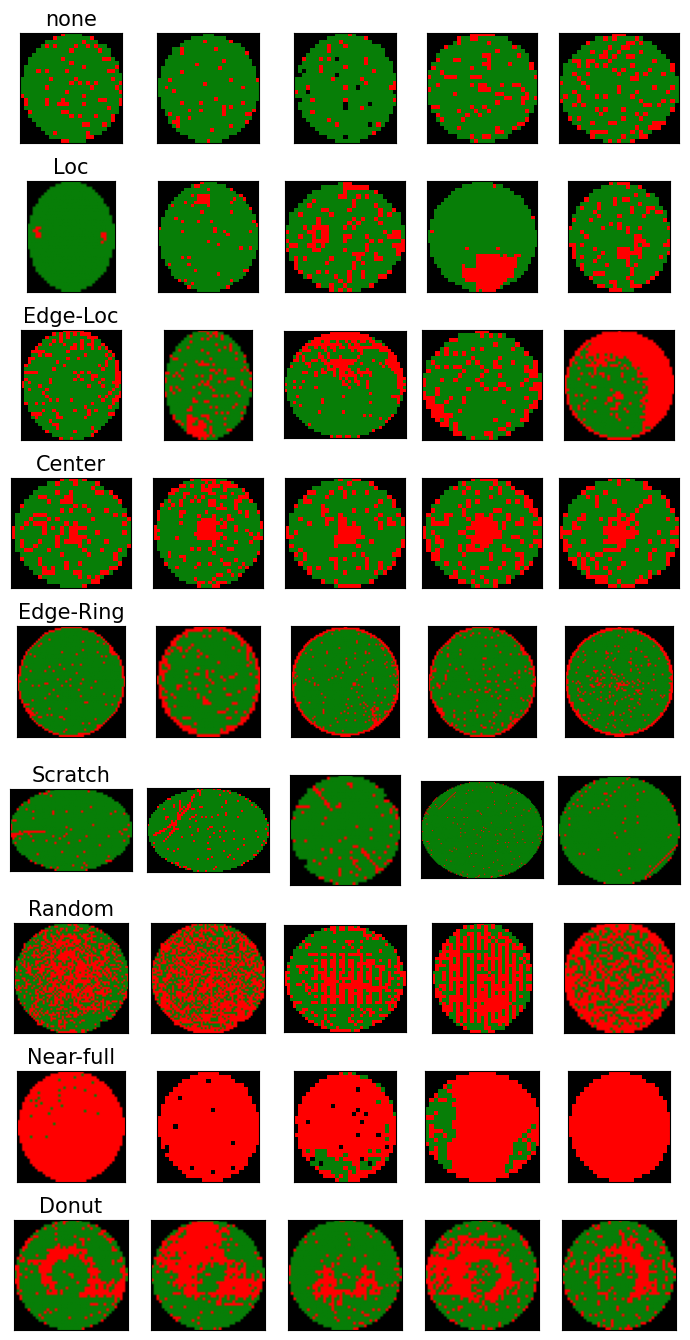

In [93]:
# Define a custom colormap
# 0: background (black)
# 1: good die (green)
# 2: defective die (red)
cmap = ListedColormap(['black', "#077e07", 'red'])

num_to_show = 5

unique_types = df_train["failureNum"].unique()   # includes 'none'

fig, axes = plt.subplots(nrows=len(unique_types), ncols=num_to_show, figsize=(7,1.5*len(unique_types)))

for row_idx, type in enumerate(unique_types):
    # sample 5 wafers of this type
    subset = df_train[df_train["failureNum"] == type].sample(n=num_to_show, random_state=42)

    for col_idx, wafer in enumerate(subset["waferMap"]):
        ax = axes[row_idx, col_idx]
        ax.imshow(wafer, cmap=cmap)
        ax.set_xticks([])
        ax.set_yticks([])

        if col_idx == 0:  # only label once per row
            label = subset.failureType.iloc[0][0][0]  # first element of the first row
            ax.set_title(label, fontsize=15, pad=5) 
plt.tight_layout()
plt.show()

## 7. Data Augmentation

After looking at the training data, there is a huge imbalance in failure types (68% of the data is just 'none'). This is where data augmentation comes into play.

Data augmentation is a crucial step to handle the imbalanced dataset. We can create new training samples from the minority classes by applying transformations like flipping and rotating.

Below are some functions to augment the wafer maps. These can be used to oversample the minority classes in the `df_train` DataFrame to create a more balanced dataset for training the model.

In [94]:
def augment_wafer(wafer_map):
    """Generates augmented versions of a single wafer map."""
    augmented_maps = []
    
    # Flipped
    augmented_maps.append(np.fliplr(wafer_map))
    augmented_maps.append(np.flipud(wafer_map))
    
    # Rotated
    augmented_maps.append(np.rot90(wafer_map, 1))
    augmented_maps.append(np.rot90(wafer_map, 2))
    augmented_maps.append(np.rot90(wafer_map, 3))
    
    return augmented_maps

# Let's check the original distribution of the training data
print("Original training data distribution:")
print(df_train['failureType'].value_counts())

# Create a new list to hold our augmented data
augmented_list = []

# We'll augment the minority classes to have at least 2000 samples each
# Loop over unique failureNum classes
for failure_num in df_train['failureNum'].unique():
    if failure_num == 8:  # skip 'none'
        continue

    class_df = df_train[df_train['failureNum'] == failure_num]
    num_samples = len(class_df)
    
    if num_samples < 2000:
        # Calculate how many new samples to generate
        num_to_generate = 2000 - num_samples
        
        # Get the wafer maps for the current class
        wafers_to_augment = class_df['waferMap'].values
        
        # Generate new samples
        generated_count = 0
        while generated_count < num_to_generate:
            # Randomly pick a wafer to augment
            wafer_to_augment = wafers_to_augment[np.random.randint(0, num_samples)]
            
            # Get all augmented versions of this wafer
            augmented_wafers = augment_wafer(wafer_to_augment)
            
            # Add the new wafers to our list
            for wafer in augmented_wafers:
                if generated_count < num_to_generate:
                    new_row = class_df.iloc[0].copy()
                    new_row['waferMap'] = wafer
                    augmented_list.append(new_row)
                    generated_count += 1

# Create a new dataframe from the augmented data
df_augmented = pd.DataFrame(augmented_list)

# Concatenate the original training data with the augmented data
df_train_augmented = pd.concat([df_train, df_augmented], ignore_index=True)

print("Augmented training data distribution:")
print(df_train_augmented['failureType'].value_counts())



Original training data distribution:
failureType
[[none]]         36730
[[Edge-Ring]]     8554
[[Center]]        3462
[[Edge-Loc]]      2417
[[Loc]]           1620
[[Random]]         609
[[Scratch]]        500
[[Donut]]          409
[[Near-full]]       54
Name: count, dtype: int64
Augmented training data distribution:
failureType
[[none]]         36730
[[Edge-Ring]]     8554
[[Center]]        3462
[[Edge-Loc]]      2417
[[Loc]]           2000
[[Scratch]]       2000
[[Random]]        2000
[[Near-full]]     2000
[[Donut]]         2000
Name: count, dtype: int64


Visualization of the different sizes of the wafermaps. This will help decide what the input size of the data should be changed to in order to train

--- Frequency of Unique Wafer Map Sizes ---
     height  width  count
0        25     27  16264
1        27     25   9711
2        26     26   6869
3        38     36   1880
4        33     37   1837
..      ...    ...    ...
417      29     28      1
418      29     35      1
419      29     45      1
420     109    111      1
421      15      3      1

[422 rows x 3 columns]


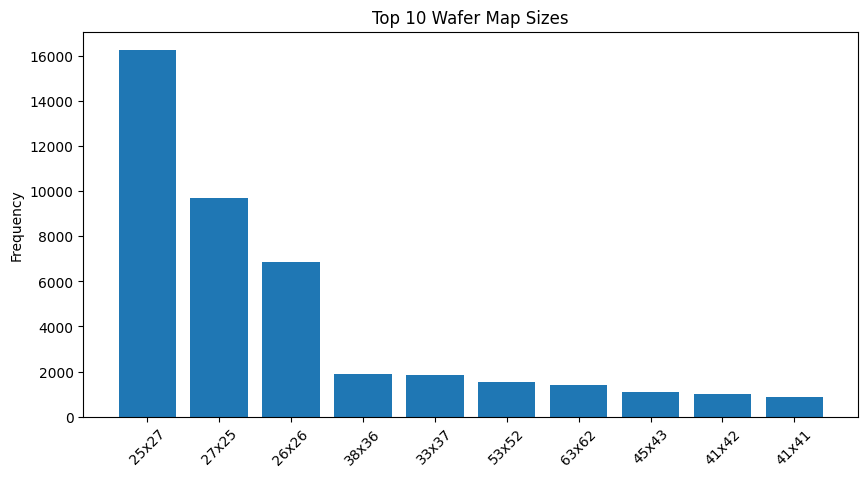

In [95]:
# Get the dimensions of each wafer map
dims = df_train_augmented['waferMap'].apply(lambda x: x.shape)

# Convert to a DataFrame of (height, width)
dims_df = pd.DataFrame(dims.tolist(), columns=['height', 'width'])

# Count frequency of each unique size
size_counts = dims_df.value_counts().reset_index(name='count')
size_counts = size_counts.sort_values(by='count', ascending=False)

print("--- Frequency of Unique Wafer Map Sizes ---")
print(size_counts)

# Optional: plot the top 10 most common sizes
top_sizes = size_counts.head(10)
plt.figure(figsize=(10,5))
plt.bar([f"{h}x{w}" for h, w in zip(top_sizes['height'], top_sizes['width'])],
        top_sizes['count'])
plt.xticks(rotation=45)
plt.ylabel("Frequency")
plt.title("Top 10 Wafer Map Sizes")
plt.show()


## 8. Data Preparation for the Model

Now we will prepare the data for training. This involves:
1.  Separating features (X) and labels (y).
2.  Reshaping and normalizing the wafer map images.
3.  Splitting the augmented training data into training and validation sets.

In [ ]:
# All wafer maps need to be resized to a single size for the CNN input
TARGET_SIZE = (25, 27)

def preprocess_wafers(df, target_size):
    """Resizes and preprocesses a dataframe of wafer maps."""
    resized_maps = []
    for i in range(len(df)):
        wafer = df['waferMap'].iloc[i]
        # Resize the image and normalize it to the range [0, 1]
        resized_wafer = resize(wafer, target_size, anti_aliasing=True)
        resized_maps.append(resized_wafer)
    
    # Convert the list of resized maps to a 4D numpy array (samples, height, width, channels)
    X = np.stack(resized_maps).astype('float32')
    X = X.reshape(-1, target_size[0], target_size[1], 1)
    
    y = df['failureNum'].astype("int32").values
    return X, y

# Preprocess the augmented training and test sets
X, y = preprocess_wafers(df_train_augmented, TARGET_SIZE)


# Split the augmented training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training data shape: {X_train.shape}')
print(f'Training labels shape: {y_train.shape}')
print(f'Validation data shape: {X_val.shape}')
print(f'Validation labels shape: {y_val.shape}')
print(f'Test data shape: {X_test.shape}')
print(f'Test labels shape: {y_test.shape}')

Training data shape: (48930, 25, 27, 1)
Training labels shape: (48930,)
Validation data shape: (12233, 25, 27, 1)
Validation labels shape: (12233,)
Test data shape: (118595, 25, 27, 1)
Test labels shape: (118595,)


## 9. Model Training

Now we can train the model using our prepared training and validation data.

In [116]:
from keras.callbacks import EarlyStopping
from scipy import stats
from sklearn.utils import class_weight

# Calculate class weights to handle data imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

EPOCHS = 15
BATCH_SIZE = 32

# To avoid overtraining, we use an early stop if validation loss stops improving
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/15
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 118s 76ms/step - accuracy: 0.9505 - loss: 0.1684 - val_accuracy: 0.7381 - val_loss: 1.0132
Epoch 2/15
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 110s 72ms/step - accuracy: 0.9498 - loss: 0.1372 - val_accuracy: 0.6530 - val_loss: 4.9161
Epoch 3/15
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 99s 65ms/step - accuracy: 0.9610 - loss: 0.0965 - val_accuracy: 0.4437 - val_loss: 11.3631
Epoch 4/15
1530/1530 ━━━━━━━━━━━━━━━━━━━━ 103s 67ms/step - accuracy: 0.9492 - loss: 0.1141 - val_accuracy: 0.8542 - val_loss: 4.6759


## 10. Visualize Training History

Plotting the model's accuracy and loss over epochs helps us understand the training process.

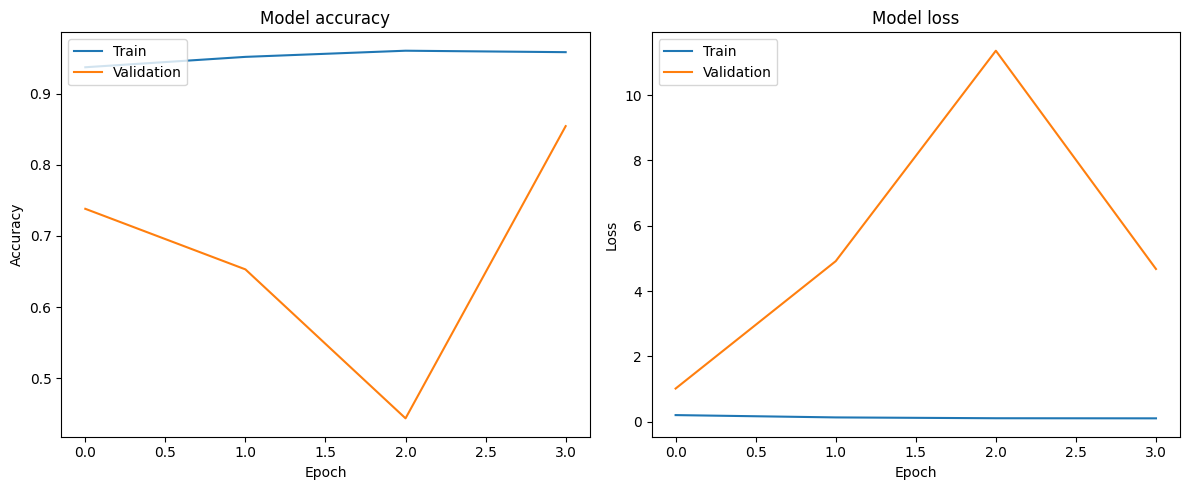

In [119]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## 11. Evaluate the Model

Let's evaluate the final model on the test set to see how well it generalizes to new, unseen data.

In [111]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 330.2442
Test Accuracy: 0.0015


### 11.2 Confusion Matrix

C:\Users\augus\AppData\Local\Temp\ipykernel_41844\767923065.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby("failureNum", group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)


Index(['waferMap', 'dieSize', 'lotName', 'trainTestLabel', 'failureType',
       'failureNum', 'trainTestNum'],
      dtype='object')
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
              precision    recall  f1-score   support

      Center       0.87      0.30      0.44       500
       Donut       0.75      0.77      0.76       146
    Edge-Loc       0.81      0.36      0.50       500
   Edge-Ring       0.88      0.85      0.86       500
         Loc       0.71      0.16      0.26       500
      Random       0.85      0.66      0.74       257
     Scratch       0.25      0.95      0.40       500
   Near-full       0.92      0.87      0.90        95
        none       0.47      0.17      0.25       500

    accuracy                           0.50      3498
   macro avg       0.72      0.57      0.57      3498
weighted avg       0.69      0.50      0.50      3498



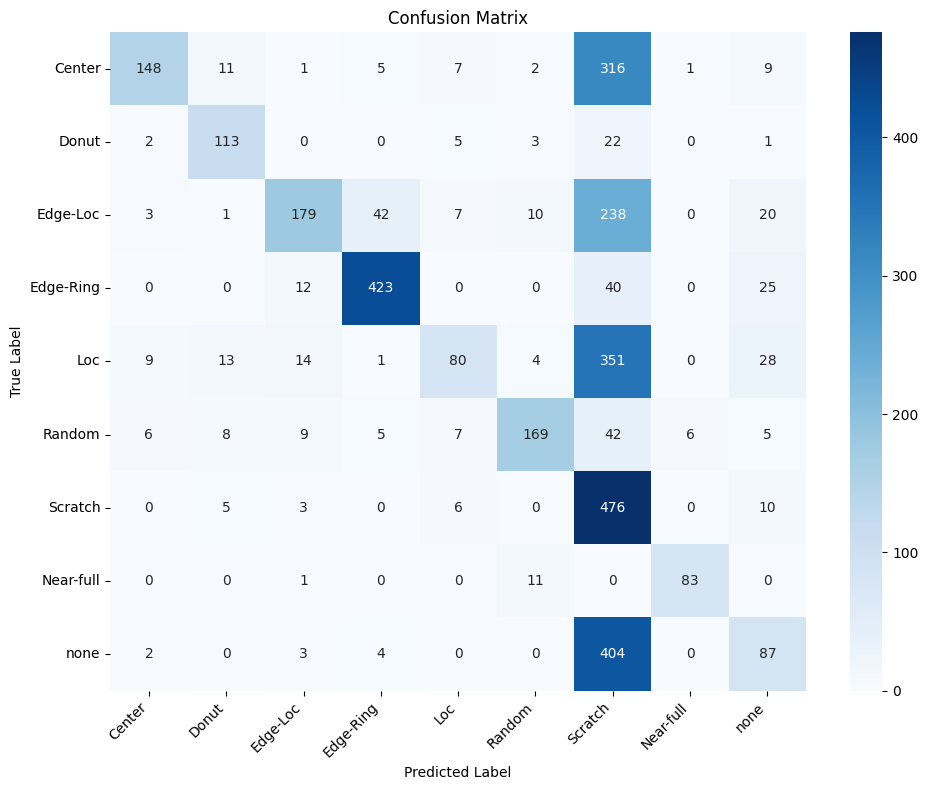

In [127]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# To get the corresponding labels for each failure number
labels = [key for key, value in sorted(mapping_type.items(), key=lambda item: item[1])]

# Balancing the test data since most of it is just "None"
# Getting a max of 500 per class
df_test_balanced = df_test.groupby("failureNum", group_keys=False).apply(lambda x: x.sample(min(len(x), 500), random_state=42)).reset_index(drop=True)
print(df_test.columns)

X_test_balanced, y_test_balanced = preprocess_wafers(df_test_balanced, TARGET_SIZE)


# Predict on test set
y_pred = model.predict(X_test_balanced).argmax(axis=1)

# Print per-class precision/recall/F1
print(classification_report(y_test_balanced, y_pred, target_names=labels))

# Confusion matrix
cm = confusion_matrix(y_test_balanced, y_pred)

plt.figure(figsize=(10, 8)) # Adjusted size for better readability
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap
plt.yticks(rotation=0)
plt.tight_layout() # Adjust layout to make room for label
plt.show()

In [128]:
# See the first 50 predictions vs labels
print("Predicted:", y_pred[:100])
print("True:", y_test_balanced[:100])

Predicted: [0 6 0 6 6 6 6 0 0 6 0 6 0 8 8 0 0 6 0 6 6 0 6 3 0 6 1 3 0 0 6 6 0 0 6 6 6
 6 6 0 0 6 8 6 0 6 6 6 6 6 6 6 6 6 6 6 6 0 6 6 6 6 6 6 6 2 6 6 6 6 0 0 0 8
 6 0 6 6 6 6 6 6 6 0 8 0 6 6 0 5 6 6 4 6 0 6 6 0 6 0]
True: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 12. Save the Trained Model

Finally, we'll save the trained model to a file so it can be loaded and used later without retraining.

In [ ]:
# model_dir = os.path.join('..', 'models')
# if not os.path.exists(model_dir):
#     os.makedirs(model_dir)

# model_path = os.path.join(model_dir, 'wafer_defect_model.h5')
# model.save(model_path)
# print(f'Model saved to {model_path}')